# Logistic Regression on DonorsChoose

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import time
from tqdm import tqdm
import os

# from plotly import plotly
# import plotly.offline as offline
# import plotly.graph_objs as go
# offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [2]:
project_data = pd.read_csv('./train_data.csv')
resources_data = pd.read_csv('./resources.csv')
print(project_data.shape)
print(project_data.columns.values)

(109248, 17)
['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [3]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x == 'project_submitted_datetime' else x for x in list(project_data.columns)]

#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Math & Science,"Applied Sciences, Health & Life Science",Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Special Needs,Special Needs,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1


In [4]:
print(resources_data.shape)
print(resources_data.columns.values)

(1541272, 4)
['id' 'description' 'quantity' 'price']


In [5]:
price_data = resources_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

## 1.2 Preprocessing of project_subject_categories

In [6]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Preprocessing of project_subject_subcategories

In [7]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.4 Text Preprocessing of essays

In [8]:
# merge two column text dataframe: 
project_data["essays"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)
project_data['essays'][2000]

'\\"Creativity is intelligence having fun.\\" --Albert Einstein. Our elementary library at Greenville Elementary is anything but a quiet, hushed space. It\'s a place for collaboration and research. It\'s a place for incorporating technology. It\'s a place for innovation. And it\'s a place for creating.Our school serves 350 third and fourth graders who primarily live in rural and poverty-stricken areas in our community. Being a Title I school, approximately 85% of them receive free or reduced lunch. But they are inquisitive, creative, and eager to learn. They love visiting the library to check out books, hear \\r\\nstories, create digital stories, and use the computer lab for learning and fun. We want to build our library\'s Makerspace with activities revolving around art and literacy to provide more engaging, hands-on activities.We want to begin \\"Makerspace Fridays!\\" Our school recently received a $1000 grant for books for our arts-integrated Makerspace. We have received titles suc

In [9]:
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
# https://gist.github.com/sebleier/554280

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [11]:
# https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string/5843547#5843547

from bs4 import BeautifulSoup
from tqdm import tqdm

preprocessed_essays = [];
for sentence in tqdm(project_data['essays'].values):
    sentence = re.sub(r"http\S+", '',sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", '', sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+',' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sentence)

100%|██████████| 109248/109248 [01:12<00:00, 1504.71it/s]


## 1.5 Text Preprocessing of project_title

In [12]:
preprocessed_titles = [];
for sentence in tqdm(project_data['project_title'].values):
    sentence = re.sub(r"http\S+", '',sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", '', sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+',' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_titles.append(sentence)

100%|██████████| 109248/109248 [00:29<00:00, 3761.00it/s]


In [13]:
project_data['clean_essays'] = preprocessed_essays
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

In [14]:
project_data['clean_titles'] = preprocessed_titles

#https://stackoverflow.com/questions/42224700/attributeerror-float-object-has-no-attribute-split
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna('null')

## 1.6 Preprocessing of Teacher Prefix

In [15]:
project_data['teacher_prefix'].unique()
 

array(['Mrs.', 'Ms.', 'Mr.', 'Teacher', 'null', 'Dr.'], dtype=object)

## 1.7 Computing Sentiment Scores

In [16]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
sentiment_scores = []

for essay in project_data['clean_essays']:
    ss = sid.polarity_scores(essay)
    sentiment_scores.append(ss)
    
neg_sentiment_score = []
neu_sentiment_score = []
pos_sentiment_score = []
comp_sentiment_score = []

for item in sentiment_scores:
    neg_sentiment_score.append(item['neg'])
    neu_sentiment_score.append(item['neu'])
    pos_sentiment_score.append(item['pos'])
    comp_sentiment_score.append(item['compound'])

In [17]:
project_data['essays_neg_score'] = neg_sentiment_score
project_data['essays_neu_score'] = neu_sentiment_score
project_data['essays_pos_score'] = pos_sentiment_score
project_data['essays_comp_score'] = comp_sentiment_score

## 1.8 Computing number of words in essays and titles

In [18]:
essay_word_count = project_data['clean_essays'].str.split().apply(len)
title_word_count = project_data['clean_titles'].str.split().apply(len)
project_data['clean_essays_word_count'] = essay_word_count
project_data['clean_titles_word_count'] = title_word_count

## 2. Splitting the data

In [19]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
x = project_data

In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33,stratify=y)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(73196, 23) (73196,)
(36052, 23) (36052,)


## 3. Preparing data for model

In [21]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'quantity', 'price',
       'clean_categories', 'clean_subcategories', 'essays', 'clean_essays',
       'clean_titles', 'essays_neg_score', 'essays_neu_score',
       'essays_pos_score', 'essays_comp_score', 'clean_essays_word_count',
       'clean_titles_word_count'],
      dtype='object')

We are going to consider only the following features :-

1. Categorical Data
   - teacher_prefix
   - school_state
   - project_grade_category
   - clean_categories
   - cleaned_subcategories
   
   
2. Text Data
   - project_title
   - Essays
   - project_resources
   
   
3. Numerical Data
   - price
   - quantity
   - teacher_number_of_previously_posted_projects
   - resource_summary_contains_number
   - clean_essays_word_count
   - clean_titles_word_count
   - essays_neg_score
   - essays_neu_score
   - essays_pos_score
   - essays_comp_score

### 3.1 Vectorizing Categorical Data

#### 1. Clean Categories

In [22]:
proj_cat_vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
x_train_categories_one_hot = proj_cat_vectorizer.fit_transform(x_train['clean_categories'].values)
# x_cv_categories_one_hot = proj_cat_vectorizer.fit_transform(x_cv['clean_categories'].values)
x_test_categories_one_hot = proj_cat_vectorizer.fit_transform(x_test['clean_categories'].values)
print(x_train_categories_one_hot.shape)
# print(x_cv_categories_one_hot.shape)
print(x_test_categories_one_hot.shape)

(73196, 9)
(36052, 9)


#### 2. Clean Subcategories

In [23]:
proj_subcat_vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
x_train_subcategories_one_hot = proj_subcat_vectorizer.fit_transform(x_train['clean_categories'].values)
# x_cv_subcategories_one_hot = proj_subcat_vectorizer.fit_transform(x_cv['clean_categories'].values)
x_test_subcategories_one_hot = proj_subcat_vectorizer.fit_transform(x_test['clean_categories'].values)
print(x_train_subcategories_one_hot.shape)
# print(x_cv_subcategories_one_hot.shape)
print(x_test_subcategories_one_hot.shape)

(73196, 30)
(36052, 30)


#### 3. Project Grade Category

In [24]:
my_counter = Counter()
for word in project_data['project_grade_category'].values:
    my_counter.update(word.split())
project_grade_cat_dict = dict(my_counter)

In [25]:
# https://stackoverflow.com/questions/4406501/change-the-name-of-a-key-in-dictionary

project_grade_cat_dict['Grades PreK-2'] = project_grade_cat_dict['PreK-2']
project_grade_cat_dict['Grades 6-8'] = project_grade_cat_dict['6-8']
project_grade_cat_dict['Grades 3-5'] = project_grade_cat_dict['3-5']
project_grade_cat_dict['Grades 9-12'] = project_grade_cat_dict['9-12']
del project_grade_cat_dict['Grades']
del project_grade_cat_dict['PreK-2']
del project_grade_cat_dict['6-8']
del project_grade_cat_dict['3-5']
del project_grade_cat_dict['9-12']
project_grade_cat_dict_sort = dict(sorted(project_grade_cat_dict.items(), key = lambda kv: kv[1]))

In [26]:
project_grade_vectorizer = CountVectorizer(vocabulary=list(project_grade_cat_dict_sort.keys()), lowercase=False, binary=True)

x_train_project_grade_categories_one_hot = project_grade_vectorizer.fit_transform(x_train['project_grade_category'].values)
# x_cv_project_grade_categories_one_hot = project_grade_vectorizer.fit_transform(x_cv['project_grade_category'].values)
x_test_project_grade_categories_one_hot = project_grade_vectorizer.fit_transform(x_test['project_grade_category'].values)
print(x_train_project_grade_categories_one_hot.shape)
# print(x_cv_project_grade_categories_one_hot.shape)
print(x_test_project_grade_categories_one_hot.shape)


(73196, 4)
(36052, 4)


#### 4. Teacher Prefix

In [27]:
my_counter = Counter()
for word in project_data['teacher_prefix'].values:
    if str(word) != 'null':
        my_counter.update(str(word).split())
teacher_prefix_dict = dict(my_counter)
teacher_prefix_dict_sort = dict(sorted(teacher_prefix_dict.items(), key = lambda kv: kv[1]))
teacher_prefix_dict_sort.items()

dict_items([('Mrs.', 57269), ('Ms.', 38955), ('Dr.', 13), ('Teacher', 2360), ('Mr.', 10648)])

In [28]:
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document

teacher_prefix_vectorizer = CountVectorizer(vocabulary=list(teacher_prefix_dict_sort.keys()), lowercase=False, binary=True)
x_train_teacher_prefix_one_hot = teacher_prefix_vectorizer.fit_transform(x_train['teacher_prefix'].values.astype('U'))
# x_cv_teacher_prefix_one_hot = teacher_prefix_vectorizer.fit_transform(x_cv['teacher_prefix'].values.astype('U'))
x_test_teacher_prefix_one_hot = teacher_prefix_vectorizer.fit_transform(x_test['teacher_prefix'].values.astype('U'))
print(x_train_teacher_prefix_one_hot.shape)
# print(x_cv_teacher_prefix_one_hot.shape)
print(x_test_teacher_prefix_one_hot.shape)

(73196, 5)
(36052, 5)


#### 5. School State

In [29]:
my_counter = Counter()
for word in project_data['school_state'].values:
    my_counter.update(word.split())
school_state_dict = dict(my_counter)
school_state_dict_sort = dict(sorted(school_state_dict.items(), key = lambda kv: kv[1]))

In [30]:
school_state_vectorizer = CountVectorizer(vocabulary=list(school_state_dict_sort.keys()), lowercase=False, binary=True)
x_train_school_state_one_hot = school_state_vectorizer.fit_transform(x_train['school_state'].values.astype('U'))
# x_cv_school_state_one_hot = school_state_vectorizer.fit_transform(x_cv['school_state'].values.astype('U'))
x_test_school_state_one_hot = school_state_vectorizer.fit_transform(x_test['school_state'].values.astype('U'))
print(x_train_school_state_one_hot.shape)
# print(x_cv_school_state_one_hot.shape)
print(x_test_school_state_one_hot.shape)


(73196, 51)
(36052, 51)


### 3.2 Vectorizing Text Data

#### 1. Essays

##### Bag of Words (BoW)

In [31]:
bow_vectorizer_essays = CountVectorizer(min_df = 10, ngram_range=(1,2), max_features=5000)

x_train_essays_bow = bow_vectorizer_essays.fit_transform(x_train['clean_essays'])
# x_cv_essays_bow = bow_vectorizer_essays.transform(x_cv['clean_essays'])
x_test_essays_bow = bow_vectorizer_essays.transform(x_test['clean_essays'])
print(x_train_essays_bow.shape)
# print(x_cv_essays_bow.shape)
print(x_test_essays_bow.shape)

(73196, 5000)
(36052, 5000)


##### TFIDF Vectorizer

In [32]:
tfidf_vectorizer_essays = TfidfVectorizer(min_df = 10, ngram_range=(1,2), max_features=5000)

x_train_essays_tfidf = tfidf_vectorizer_essays.fit_transform(x_train['clean_essays'])
# x_cv_essays_tfidf = tfidf_vectorizer_essays.transform(x_cv['clean_essays'])
x_test_essays_tfidf = tfidf_vectorizer_essays.transform(x_test['clean_essays'])
print(x_train_essays_tfidf.shape)
# print(x_cv_essays_tfidf.shape)
print(x_test_essays_tfidf.shape)

(73196, 5000)
(36052, 5000)


##### Average Word2Vector (AVG W2V)

In [33]:
# Taking referrence from Amazon Fine Food Reviews

# essays_sentences = []
# for sentence in x_train['clean_essays']:
#     essays_sentences.append(sentence)

In [34]:
# essays_w2v_model = Word2Vec(essays_sentences, min_count=5, size=300, workers=5) 
# essays_w2v_words = essays_w2v_model.wv.vocab
# essays_w2v_words

In [35]:
# x_train_essays_w2v_vectors = []

# for sent in tqdm(x_train['clean_essays']):
#     sent_vec= np.zeros(300)
#     count=0
#     for word in sent:
#         if word in essays_w2v_words:
#             vec = essays_w2v_model.wv[word]
#             sent_vec += vec
#             count += 1
#     if count != 0:
#         sent_vec /= count
#         x_train_essays_w2v_vectors.append(sent_vec)

# print(len(x_train_essays_w2v_vectors))
# print(len(x_train_essays_w2v_vectors[0]))

# # x_cv_essays_w2v_vectors = []

# # for sent in tqdm(x_cv['clean_essays']):
# #     sent_vec= np.zeros(300)
# #     count=0
# #     for word in sent:
# #         if word in essays_w2v_words:
# #             vec = essays_w2v_model.wv[word]
# #             sent_vec += vec
# #             count += 1
# #     if count != 0:
# #         sent_vec /= count
# #         x_cv_essays_w2v_vectors.append(sent_vec)

# # print(len(x_cv_essays_w2v_vectors))
# # print(len(x_cv_essays_w2v_vectors[0]))

# x_test_essays_w2v_vectors = []

# for sent in tqdm(x_test['clean_essays']):
#     sent_vec= np.zeros(300)
#     count=0
#     for word in sent:
#         if word in essays_w2v_words:
#             vec = essays_w2v_model.wv[word]
#             sent_vec += vec
#             count += 1
#     if count != 0:
#         sent_vec /= count
#         x_test_essays_w2v_vectors.append(sent_vec)

# print(len(x_test_essays_w2v_vectors))
# print(len(x_test_essays_w2v_vectors[0]))

##### TFIDF weighted W2V

In [36]:
# # Taking referrence from Amazon Fine Food Reviews

# model = TfidfVectorizer()
# model.fit(x_train['clean_essays'])
# essays_tfidf_dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [37]:
# essays_tfidf_words = set(model.get_feature_names())
# x_train_essays_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sentence in tqdm(x_train['clean_essays']): # for each review/sentence
#     vector = np.zeros(300) # as word vectors are of zero length
#     tf_idf_weight =0; # num of words with a valid vector in the sentence/review
#     for word in sentence.split(): # for each word in a review/sentence
#         if (word in essays_w2v_words) and (word in essays_tfidf_words):
#             vec = w2v_model.wv[word] # getting the vector for each word
#             # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
#             tf_idf = essays_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
#             vector += (vec * tf_idf) # calculating tfidf weighted w2v
#             tf_idf_weight += tf_idf
#     if tf_idf_weight != 0:
#         vector /= tf_idf_weight
#     x_train_essays_tfidf_w2v_vectors.append(vector)

# print(len(x_train_essays_tfidf_w2v_vectors))
# print(len(x_train_essays_tfidf_w2v_vectors[0]))

# x_cv_essays_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sentence in tqdm(x_cv['clean_essays']): # for each review/sentence
#     vector = np.zeros(300) # as word vectors are of zero length
#     tf_idf_weight =0; # num of words with a valid vector in the sentence/review
#     for word in sentence.split(): # for each word in a review/sentence
#         if (word in essays_w2v_words) and (word in essays_tfidf_words):
#             vec = w2v_model.wv[word] # getting the vector for each word
#             # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
#             tf_idf = essays_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
#             vector += (vec * tf_idf) # calculating tfidf weighted w2v
#             tf_idf_weight += tf_idf
#     if tf_idf_weight != 0:
#         vector /= tf_idf_weight
#     x_cv_essays_tfidf_w2v_vectors.append(vector)

# print(len(x_cv_essays_tfidf_w2v_vectors))
# print(len(x_cv_essays_tfidf_w2v_vectors[0]))

# x_test_essays_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sentence in tqdm(x_test['clean_essays']): # for each review/sentence
#     vector = np.zeros(300) # as word vectors are of zero length
#     tf_idf_weight =0; # num of words with a valid vector in the sentence/review
#     for word in sentence.split(): # for each word in a review/sentence
#         if (word in essays_w2v_words) and (word in essays_tfidf_words):
#             vec = w2v_model.wv[word] # getting the vector for each word
#             # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
#             tf_idf = essays_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
#             vector += (vec * tf_idf) # calculating tfidf weighted w2v
#             tf_idf_weight += tf_idf
#     if tf_idf_weight != 0:
#         vector /= tf_idf_weight
#     x_test_essays_tfidf_w2v_vectors.append(vector)

# print(len(x_test_essays_tfidf_w2v_vectors))
# print(len(x_test_essays_tfidf_w2v_vectors[0]))

#### 2. Title

##### Bag of Words (Bow)

In [38]:
bow_vectorizer_title = CountVectorizer(min_df = 10)

x_train_titles_bow = bow_vectorizer_title.fit_transform(x_train['clean_titles'])
# x_cv_titles_bow = bow_vectorizer_title.transform(x_cv['clean_titles'])
x_test_titles_bow = bow_vectorizer_title.transform(x_test['clean_titles'])
print(x_train_titles_bow.shape)
# print(x_cv_titles_bow.shape)
print(x_test_titles_bow.shape)

(73196, 2523)
(36052, 2523)


##### TFIDF Vectorizer

In [39]:
tfidf_vectorizer_title = TfidfVectorizer(min_df = 10)

x_train_titles_tfidf = tfidf_vectorizer_title.fit_transform(x_train['clean_titles'])
# x_cv_titles_tfidf = tfidf_vectorizer_title.transform(x_cv['clean_titles'])
x_test_titles_tfidf = tfidf_vectorizer_title.transform(x_test['clean_titles'])
print(x_train_titles_tfidf.shape)
# print(x_cv_titles_tfidf.shape)
print(x_test_titles_tfidf.shape)

(73196, 2523)
(36052, 2523)


##### Average Word2Vector (W2V)

In [40]:
# # Taking referrence from Amazon Fine Food Reviews

# titles_sentences = []
# for sentence in x_train['clean_titles']:
#     titles_sentences.append(sentence)

In [41]:
# titles_w2v_model = Word2Vec(titles_sentences, min_count=1, size=300, workers=5) 
# titles_w2v_words = titles_w2v_model.wv.vocab

In [42]:
# x_train_titles_w2v_vectors = []

# for sent in tqdm(x_train['clean_titles']):
#     sent_vec= np.zeros(300)
#     count=0
#     for word in sent:
#         if word in titles_w2v_words:
#             vec = titles_w2v_model.wv[word]
#             sent_vec += vec
#             count += 1
#     if count != 0:
#         sent_vec /= count
#         x_train_titles_w2v_vectors.append(sent_vec)

# print(len(x_train_titles_w2v_vectors))
# print(len(x_train_titles_w2v_vectors[0]))

# x_cv_titles_w2v_vectors = []

# for sent in tqdm(x_cv['clean_titles']):
#     sent_vec= np.zeros(300)
#     count=0
#     for word in sent:
#         if word in titles_w2v_words:
#             vec = titles_w2v_model.wv[word]
#             sent_vec += vec
#             count += 1
#     if count != 0:
#         sent_vec /= count
#         x_cv_titles_w2v_vectors.append(sent_vec)

# print(len(x_cv_titles_w2v_vectors))
# print(len(x_cv_titles_w2v_vectors[0]))

# x_test_titles_w2v_vectors = []

# for sent in tqdm(x_test['clean_titles']):
#     sent_vec= np.zeros(300)
#     count=0
#     for word in sent:
#         if word in titles_w2v_words:
#             vec = titles_w2v_model.wv[word]
#             sent_vec += vec
#             count += 1
#     if count != 0:
#         sent_vec /= count
#         x_test_titles_w2v_vectors.append(sent_vec)

# print(len(x_test_titles_w2v_vectors))
# print(len(x_test_titles_w2v_vectors[0]))

##### TFIDF weighted W2V

In [43]:
# # Taking referrence from Amazon Fine Food Reviews

# model = TfidfVectorizer()
# model.fit(x_train['clean_titles'])
# titles_tfidf_dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [44]:
# titles_tfidf_words = set(model.get_feature_names())
# x_train_titles_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sentence in tqdm(x_train['clean_titles']): # for each review/sentence
#     vector = np.zeros(300) # as word vectors are of zero length
#     tf_idf_weight =0; # num of words with a valid vector in the sentence/review
#     for word in sentence.split(): # for each word in a review/sentence
#         if (word in titles_w2v_words) and (word in titles_tfidf_words):
#             vec = w2v_model.wv[word] # getting the vector for each word
#             # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
#             tf_idf = titles_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
#             vector += (vec * tf_idf) # calculating tfidf weighted w2v
#             tf_idf_weight += tf_idf
#     if tf_idf_weight != 0:
#         vector /= tf_idf_weight
#     x_train_titles_tfidf_w2v_vectors.append(vector)

# print(len(x_train_titles_tfidf_w2v_vectors))
# print(len(x_train_titles_tfidf_w2v_vectors[0]))

# x_cv_titles_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sentence in tqdm(x_cv['clean_titles']): # for each review/sentence
#     vector = np.zeros(300) # as word vectors are of zero length
#     tf_idf_weight =0; # num of words with a valid vector in the sentence/review
#     for word in sentence.split(): # for each word in a review/sentence
#         if (word in titles_w2v_words) and (word in titles_tfidf_words):
#             vec = w2v_model.wv[word] # getting the vector for each word
#             # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
#             tf_idf = titles_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
#             vector += (vec * tf_idf) # calculating tfidf weighted w2v
#             tf_idf_weight += tf_idf
#     if tf_idf_weight != 0:
#         vector /= tf_idf_weight
#     x_cv_titles_tfidf_w2v_vectors.append(vector)

# print(len(x_cv_titles_tfidf_w2v_vectors))
# print(len(x_cv_titles_tfidf_w2v_vectors[0]))

# x_test_titles_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sentence in tqdm(x_test['clean_titles']): # for each review/sentence
#     vector = np.zeros(300) # as word vectors are of zero length
#     tf_idf_weight =0; # num of words with a valid vector in the sentence/review
#     for word in sentence.split(): # for each word in a review/sentence
#         if (word in titles_w2v_words) and (word in titles_tfidf_words):
#             vec = w2v_model.wv[word] # getting the vector for each word
#             # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
#             tf_idf = titles_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
#             vector += (vec * tf_idf) # calculating tfidf weighted w2v
#             tf_idf_weight += tf_idf
#     if tf_idf_weight != 0:
#         vector /= tf_idf_weight
#     x_test_titles_tfidf_w2v_vectors.append(vector)

# print(len(x_test_titles_tfidf_w2v_vectors))
# print(len(x_test_titles_tfidf_w2v_vectors[0]))

### 3.3 Standardizing Numerical Data

#### 1. Price

In [45]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

price_scalar = StandardScaler()
x_train_price_standardized = price_scalar.fit_transform(x_train['price'].values.reshape(-1,1))
# x_cv_price_standardized = price_scalar.transform(x_cv['price'].values.reshape(-1,1))
x_test_price_standardized = price_scalar.transform(x_test['price'].values.reshape(-1,1))
print(x_train_price_standardized.shape)
# print(x_cv_price_standardized.shape)
print(x_test_price_standardized.shape)

(73196, 1)
(36052, 1)


In [46]:
from sklearn.preprocessing import Normalizer

price_normalizer = Normalizer()

x_train_price_normalized = price_normalizer.fit_transform(x_train['price'].values.reshape(-1,1))
# x_cv_price_normalized = price_normalizer.transform(x_cv['price'].values.reshape(-1,1))
x_test_price_normalized = price_normalizer.transform(x_test['price'].values.reshape(-1,1))

print(x_train_price_normalized)
# print(x_cv_price_normalized)
print(x_test_price_normalized)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


#### 2. Teacher Number of Previously Posted Projects

In [47]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

teacher_number_of_previously_posted_projects_scalar = StandardScaler()
x_train_teacher_number_of_previously_posted_projects_standardized = teacher_number_of_previously_posted_projects_scalar.fit_transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
# x_cv_teacher_number_of_previously_posted_projects_standardized = teacher_number_of_previously_posted_projects_scalar.transform(x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_test_teacher_number_of_previously_posted_projects_standardized = teacher_number_of_previously_posted_projects_scalar.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print(x_train_teacher_number_of_previously_posted_projects_standardized.shape)
# print(x_cv_teacher_number_of_previously_posted_projects_standardized.shape)
print(x_test_teacher_number_of_previously_posted_projects_standardized.shape)

(73196, 1)
(36052, 1)


#### 3. Clean Essays Word Count

In [48]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

clean_essays_word_count_scalar = StandardScaler()
x_train_clean_essays_word_count_standardized = clean_essays_word_count_scalar.fit_transform(x_train['clean_essays_word_count'].values.reshape(-1,1))
# x_cv_clean_essays_word_count_standardized = clean_essays_word_count_scalar.transform(x_cv['clean_essays_word_count'].values.reshape(-1,1))
x_test_clean_essays_word_count_standardized = clean_essays_word_count_scalar.transform(x_test['clean_essays_word_count'].values.reshape(-1,1))
print(x_train_clean_essays_word_count_standardized.shape)
# print(x_cv_clean_essays_word_count_standardized.shape)
print(x_test_clean_essays_word_count_standardized.shape)


(73196, 1)
(36052, 1)


#### 4. Clean Titles Word Count

In [49]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

clean_titles_word_count_scalar = StandardScaler()
x_train_clean_titles_word_count_standardized = clean_titles_word_count_scalar.fit_transform(x_train['clean_titles_word_count'].values.reshape(-1,1))
# x_cv_clean_titles_word_count_standardized = clean_titles_word_count_scalar.transform(x_cv['clean_titles_word_count'].values.reshape(-1,1))
x_test_clean_titles_word_count_standardized = clean_titles_word_count_scalar.transform(x_test['clean_titles_word_count'].values.reshape(-1,1))
print(x_train_clean_titles_word_count_standardized.shape)
# print(x_cv_clean_titles_word_count_standardized.shape)
print(x_test_clean_titles_word_count_standardized.shape)



(73196, 1)
(36052, 1)


#### 5. Essay Sentiment Scores

In [50]:
from sklearn.preprocessing import StandardScaler

essays_comp_score_scalar = StandardScaler()
x_train_essays_comp_score_standardized = essays_comp_score_scalar.fit_transform(x_train['essays_comp_score'].values.reshape(-1,1))
# x_cv_essays_comp_score_standardized = essays_comp_score_scalar.transform(x_cv['essays_comp_score'].values.reshape(-1,1))
x_test_essays_comp_score_standardized = essays_comp_score_scalar.transform(x_test['essays_comp_score'].values.reshape(-1,1))
print(x_train_essays_comp_score_standardized.shape)
# print(x_cv_essays_comp_score_standardized.shape)
print(x_test_essays_comp_score_standardized.shape)

(73196, 1)
(36052, 1)


In [51]:
from sklearn.preprocessing import StandardScaler

essays_pos_score_scalar = StandardScaler()
x_train_essays_pos_score_standardized = essays_pos_score_scalar.fit_transform(x_train['essays_pos_score'].values.reshape(-1,1))
# x_cv_essays_pos_score_standardized = essays_pos_score_scalar.transform(x_cv['essays_pos_score'].values.reshape(-1,1))
x_test_essays_pos_score_standardized = essays_pos_score_scalar.transform(x_test['essays_pos_score'].values.reshape(-1,1))
print(x_train_essays_pos_score_standardized.shape)
# print(x_cv_essays_pos_score_standardized.shape)
print(x_test_essays_pos_score_standardized.shape)

(73196, 1)
(36052, 1)


In [52]:
from sklearn.preprocessing import StandardScaler

essays_neu_score_scalar = StandardScaler()
x_train_essays_neu_score_standardized = essays_neu_score_scalar.fit_transform(x_train['essays_neu_score'].values.reshape(-1,1))
# x_cv_essays_neu_score_standardized = essays_neu_score_scalar.transform(x_cv['essays_neu_score'].values.reshape(-1,1))
x_test_essays_neu_score_standardized = essays_neu_score_scalar.transform(x_test['essays_neu_score'].values.reshape(-1,1))
print(x_train_essays_neu_score_standardized.shape)
# print(x_cv_essays_neu_score_standardized.shape)
print(x_test_essays_neu_score_standardized.shape)


(73196, 1)
(36052, 1)


In [53]:
from sklearn.preprocessing import StandardScaler

essays_neg_score_scalar = StandardScaler()
x_train_essays_neg_score_standardized = essays_neg_score_scalar.fit_transform(x_train['essays_neg_score'].values.reshape(-1,1))
# x_cv_essays_neg_score_standardized = essays_neg_score_scalar.transform(x_cv['essays_neg_score'].values.reshape(-1,1))
x_test_essays_neg_score_standardized = essays_neg_score_scalar.transform(x_test['essays_neg_score'].values.reshape(-1,1))
print(x_train_essays_neg_score_standardized.shape)
# print(x_cv_essays_neg_score_standardized.shape)
print(x_test_essays_neg_score_standardized.shape)

(73196, 1)
(36052, 1)


## Merging all Features to preapre the Data for Modelling

In [54]:
from scipy.sparse import hstack

x_tr = hstack((x_train_categories_one_hot,x_train_subcategories_one_hot,
               x_train_project_grade_categories_one_hot,x_train_teacher_prefix_one_hot,
               x_train_school_state_one_hot,x_train_price_standardized,
               x_train_essays_bow,x_train_titles_bow)).tocsr()

# x_cv = hstack((x_cv_categories_one_hot,x_cv_subcategories_one_hot,x_cv_project_grade_categories_one_hot,
#                x_cv_teacher_prefix_one_hot,x_cv_school_state_one_hot,x_cv_price_standardized,x_cv_essays_bow,
#                x_cv_titles_bow)).tocsr()

x_te = hstack((x_test_categories_one_hot,x_test_subcategories_one_hot,x_test_project_grade_categories_one_hot,
               x_test_teacher_prefix_one_hot,x_test_school_state_one_hot,x_test_price_standardized,x_test_essays_bow,
               x_test_titles_bow)).tocsr()


print("Final Data matrix")
print(x_tr.shape, y_train.shape)
# print(x_cv.shape, y_cv.shape)
print(x_te.shape, y_test.shape)

Final Data matrix
(73196, 7623) (73196,)
(36052, 7623) (36052,)


## Dimensionality Reduction on the selected features

In [55]:
from sklearn.feature_selection import SelectKBest, f_classif
t = SelectKBest(f_classif,k=5000).fit(x_tr, y_train)
x_tr = t.transform(x_tr)
x_te = t.transform(x_te)

print("Final Data matrix on TFIDF")
print(x_tr.shape, y_train.shape)

print(x_te.shape, y_test.shape)
print("="*100)

Final Data matrix on TFIDF
(73196, 5000) (73196,)
(36052, 5000) (36052,)


## Apply K-Means

In [62]:
from sklearn.cluster import KMeans, MiniBatchKMeans

k_values = [2,3,4,5,6,7,8]
loss = []
for i in k_values:
    kmeans = MiniBatchKMeans(n_clusters=i, batch_size=1000).fit(x_tr)
    loss.append(kmeans.inertia_)

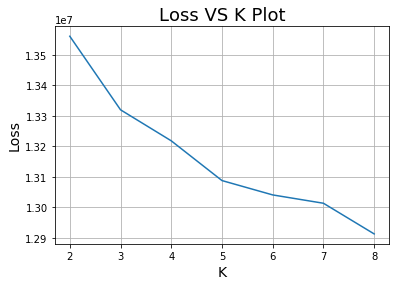

In [63]:
plt.plot(k_values, loss)
plt.xlabel('K',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K Plot',size=18)
plt.grid()
plt.show()

In [65]:
optimal_k = 6

kmeans = MiniBatchKMeans(n_clusters=optimal_k).fit(x_tr)

In [68]:
essays = x_train['clean_essays'].values

cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(essays[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(essays[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(essays[i])
    elif  kmeans.labels_[i] == 3:
        cluster4.append(essays[i])
    elif  kmeans.labels_[i] == 4:
        cluster5.append(essays[i])
    elif  kmeans.labels_[i] == 5:
        cluster6.append(essays[i])

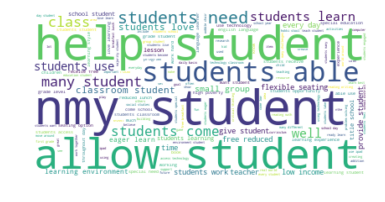

In [69]:
#cluster 1
words=''
for i in cluster1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

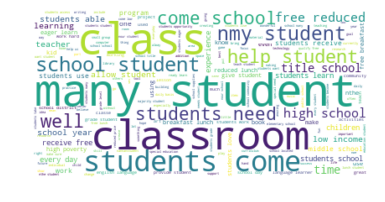

In [70]:
#cluster 2
words=''
for i in cluster2:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

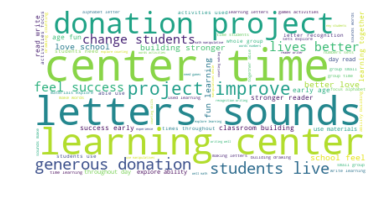

In [71]:
#cluster 3
words=''
for i in cluster3:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

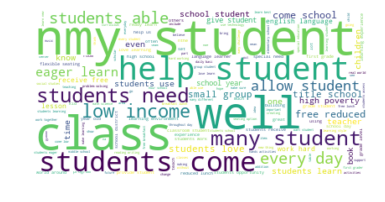

In [72]:
#cluster 4
words=''
for i in cluster4:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

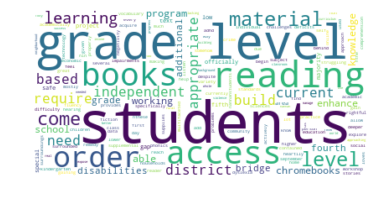

In [73]:
#cluster 5
words=''
for i in cluster5:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

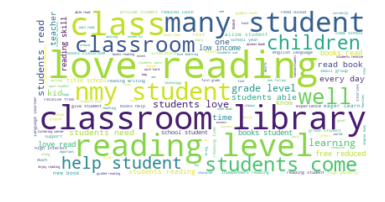

In [74]:
#cluster 6
words=''
for i in cluster6:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Apply AgglomerativeClustering

In [56]:
# As  hierarchal clustering is computationally very expensive, hence using only 1000 features

from sklearn.feature_selection import SelectKBest, f_classif
t = SelectKBest(f_classif,k=1000).fit(x_tr, y_train)
x_tr = t.transform(x_tr)
x_te = t.transform(x_te)

print("Final Data matrix on TFIDF")
print(x_tr.shape, y_train.shape)

print(x_te.shape, y_test.shape)


Final Data matrix on TFIDF
(73196, 1000) (73196,)
(36052, 1000) (36052,)


### For K=2

In [57]:
# As  hierarchal clustering is computationally very expensive, hence using only 10000 rows
from sklearn.cluster import AgglomerativeClustering

aggcl=AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2).fit(x_tr[:10000].toarray())

In [60]:
cluster1=[]
cluster2=[]
essays = x_train['clean_essays'].values
for i in range(aggcl.labels_.shape[0]):
    if aggcl.labels_[i] == 0:
        cluster1.append(essays[i])
    elif aggcl.labels_[i] == 1:
        cluster2.append(essays[i])

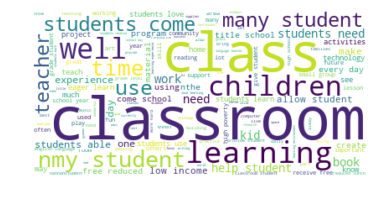

In [61]:
#cluster 1
words=''
for i in cluster1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

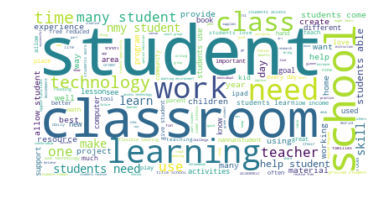

In [62]:
#cluster 2
words=''
for i in cluster2:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### For k=5

In [56]:
from sklearn.cluster import AgglomerativeClustering

aggcl=AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5).fit(x_tr[:10000].toarray())

In [57]:
cluster1=[]
cluster2=[]
cluster3=[]
cluster4=[]
cluster5=[]
essays = x_train['clean_essays'].values
for i in range(aggcl.labels_.shape[0]):
    if aggcl.labels_[i] == 0:
        cluster1.append(essays[i])
    elif aggcl.labels_[i] == 1:
        cluster2.append(essays[i])
    elif aggcl.labels_[i] == 2:
        cluster3.append(essays[i])
    elif  aggcl.labels_[i] == 3:
        cluster4.append(essays[i])
    elif  aggcl.labels_[i] == 4:
        cluster5.append(essays[i])

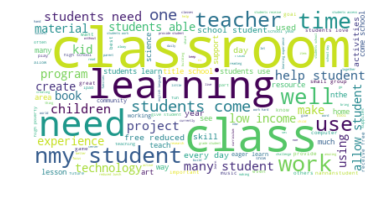

In [58]:

#cluster 1
words=''
for i in cluster1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

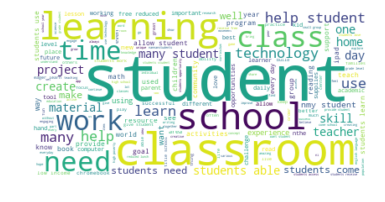

In [59]:
#cluster 2
words=''
for i in cluster2:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

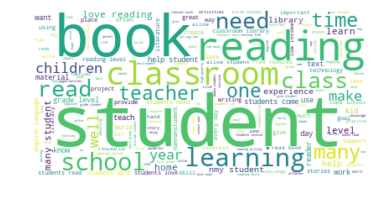

In [60]:
#cluster 3
words=''
for i in cluster3:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

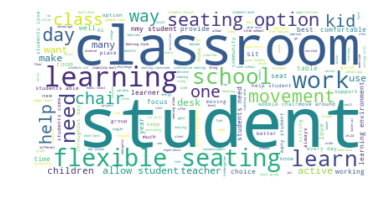

In [61]:
#cluster 4
words=''
for i in cluster4:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

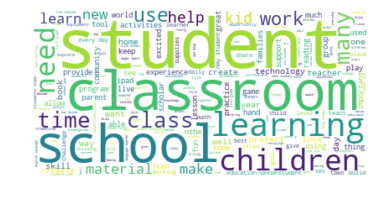

In [62]:
#cluster 5
words=''
for i in cluster5:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Apply DBSCAN

100%|██████████| 5000/5000 [05:36<00:00, 14.84it/s]


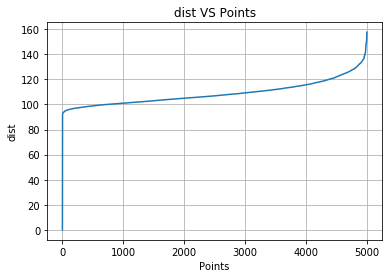

In [65]:
#https://github.com/dileepteja3/Clustering-on-Donors-choose/blob/master/dileep.teja3@gmail.com_10.ipynb

min_points = 1500
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
x_tr_std=StandardScaler().fit_transform(x_tr[:5000].toarray())

distance=[]
for point in tqdm(x_tr_std):
    temp = euclidean_distances(x_tr_std, point.reshape(1, -1))
    distance.append(temp[min_points])
sorted_distance = np.sort(np.array(distance))

sorted_dist = np.sort(sorted_distance.reshape(1,-1)[0])
points = [i for i in range(len(x_tr_std))]


# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_dist)
plt.xlabel('Points')
plt.ylabel('dist')
plt.title('dist VS Points')
plt.grid()
plt.show()

In [67]:
#we can see that point of inflexion is at eps=90
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=90,n_jobs=-1)
dbscan.fit(x_tr_std)
print('No of clusters: ',len(set(dbscan.labels_)))
print('Cluster are including noise i.e -1: ',set(dbscan.labels_))

No of clusters:  2
Cluster are including noise i.e -1:  {0, -1}


In [68]:
#ignoring -1 as it is for noise
cluster1=[]
noisecluster1=[]
for i in range(dbscan.labels_.shape[0]):
    if dbscan.labels_[i] == 0:
        cluster1.append(essays[i])
    elif dbscan.labels_[i] == -1:
        noisecluster1.append(essays[i])

In [69]:
for i in range(3):
    print('%s\n'%(cluster1[i]))

students motivated become artists cultural vibrancy downtown los angeles audition free public arts high school students enjoy rigorous art academic education students mainly low income qualifying free reduced lunch making us title school enjoy local museums ride metro thrive urban environment r n r nour school dual mission arts academic excellence students graduate ready college also study arts students many art classes high school well exhibitions participate national local art contests win scholastic art awards high school western united states hardworking kids appreciate would like love artwork mission mandate integrate arts creative ambitious certain make great use art supplies come way project put paintbrushes hands painting ap studio art design students use paint daily basis classroom never ending need paintbrushes not last students learning paint exercises also working artworks good brush necessary tool students learn master paint brush enough paint canvas brushes continual chal

In [70]:
for i in range(3):
    print('%s\n'%(noisecluster1[i]))

students make every new day exciting fun come tight knit community share not many common values also great pride school community students siblings parents aunts uncles know words school alma mater love sing pleasure surrounded school spirit r n r nin classroom students pull together help one another get challenges come different grade levels different cultural ethnic backgrounds different religions yet sense ohana family shines everyday working together students need posters remind strive excellence always best always remind things would beneficial constant reminder around daily learning environment also need posters reinforce concepts learn class r n r nmy students need supplies allow create posters reinforce learning quadratic formula slope intercept form divide number zero get real number want students supplies create reminders help peers remember answers questions allowing creativity personalities shine r n r nmy students also need basic health supplies like hand sanitizer kleenex

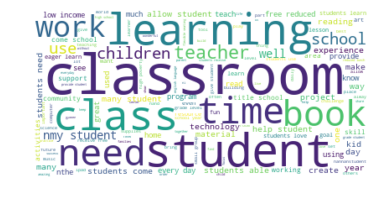

In [71]:
#cluster 1
words=''
for i in cluster1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

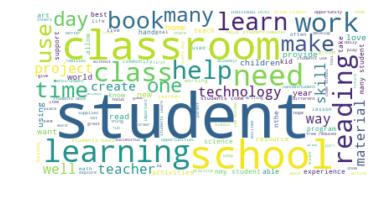

In [72]:
#noise cluster 1
words=''
for i in noisecluster1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Conclusions

### K-Means

In [73]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer","Best k"]
x.add_row(['TFIDF','6'])
print(x)

+------------+--------+
| Vectorizer | Best k |
+------------+--------+
|   TFIDF    |   6    |
+------------+--------+


### Agglomerative

In [74]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer","Best k"]
x.add_row(['TFIDF','2'])
x.add_row(['TFIDF','5'])
print(x)

+------------+--------+
| Vectorizer | Best k |
+------------+--------+
|   TFIDF    |   2    |
|   TFIDF    |   5    |
+------------+--------+


### DBSCAN

In [75]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer","Best k","Eps","Number of clusters(INCLUDING NOISE)"]
x.add_row(['TFIDF','2',90,2])
print(x)

+------------+--------+-----+-------------------------------------+
| Vectorizer | Best k | Eps | Number of clusters(INCLUDING NOISE) |
+------------+--------+-----+-------------------------------------+
|   TFIDF    |   2    |  90 |                  2                  |
+------------+--------+-----+-------------------------------------+
